In [1]:
from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder :
    
    def __init__(self, seq_len, channel_map) :
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


In [2]:
#Load data

batch_size = 32

dataset_name = "coiled_coil_binders"
experiment = "coiled_coil_binders_alyssa"

npzfile = np.load("../../scrambler_pytorch_coiled_coil_binders/" + dataset_name + "_" + experiment + ".npz")

x_1_test = npzfile['x_1_test']
x_2_test = npzfile['x_2_test']
l_1_test = npzfile['l_1_test']
l_2_test = npzfile['l_2_test']
y_test = npzfile['y_test']

x_test = np.concatenate([x_1_test, x_2_test], axis=2)

#Add padding to images
padding = 30

x_test_padded = np.concatenate([
    x_test,
    np.zeros((x_test.shape[0], x_test.shape[1], padding, x_test.shape[3]))
], axis=2)

print("padded x_test.shape = " + str(x_test_padded.shape))


padded x_test.shape = (480, 1, 192, 20)


In [3]:
from sal.saliency_model_sequence import SaliencyModel, get_black_box_fn
from sal.utils.resnet_encoder_sequence import resnet50encoder

model_save_str = "pytorch_saliency_model_coiled_coil_binders_smaller_blur_resnet50_n_epochs_phase1_0_phase2_20"

saliency = SaliencyModel(resnet50encoder(pretrained_f=None, num_classes=2), 5, 64, 3, 64, fix_encoder=False, use_simple_activation=False, allow_selector=False, num_classes=2)
saliency.restore(model_save_str)


In [4]:
#Create pytorch input tensor

x_test_padded_pytorch = Variable(torch.FloatTensor(np.transpose(x_test_padded, (0, 3, 1, 2))))
x_test_padded_pytorch = x_test_padded_pytorch.cuda()

device = torch.device('cuda:0')

saliency.to(device)
x_test_padded_pytorch = x_test_padded_pytorch.to(device)


In [5]:

n_batches = x_test.shape[0] // batch_size

masks_padded = []

with torch.no_grad() :
    for batch_ix in range(n_batches) :

        x_batch = x_test_padded_pytorch[batch_ix * batch_size:(batch_ix + 1) * batch_size, ...]

        mask_batch = saliency(x_batch)[0]

        if mask_batch.size()[-2:] != x_batch.size()[-2:]:
            mask_batch = F.upsample(mask_batch, (x_batch.size(2), x_batch.size(3)), mode='bilinear')
        
        mask_batch = mask_batch.cpu().numpy()
        
        masks_padded.append(mask_batch)

masks_padded = np.concatenate(masks_padded, axis=0)
masks_padded = np.transpose(masks_padded, (0, 2, 3, 1))

masks = masks_padded[:, :, :-padding, :]

print("masks.shape = " + str(masks.shape))


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


masks.shape = (480, 1, 162, 1)


In [6]:

def _unpool(masks, unpool_factor=2) :
    
    masks_unpooled = np.zeros((masks.shape[0], masks.shape[1] * unpool_factor, masks.shape[2] * unpool_factor, 1))
    
    for i in range(masks_unpooled.shape[1]) :
        for j in range(masks_unpooled.shape[2]) :
            masks_unpooled[:, i, j, 0] = masks[:, i // unpool_factor, j // unpool_factor, 0]

    return masks_unpooled

importance_scores_test = _unpool(masks, unpool_factor=1)

importance_scores_1_test = importance_scores_test[:, :, :81, :]
importance_scores_2_test = importance_scores_test[:, :, 81:, :]


In [7]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [8]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_protein_logo(residue_map, pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164) :

    inv_residue_map = {
        i : sp for sp, i in residue_map.items()
    }

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(np.clip(pwm[pwm > 0], 1e-6, 1. - 1e-6))
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(residue_map)) :
            i = sort_index[ii]
            
            if pwm[j, i] > 0 :
                nt_prob = pwm[j, i] * conservation[j]

                nt = inv_residue_map[i]

                color = None
                if sequence_template[j] != '$' :
                    color = 'black'

                if ii == 0 :
                    letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        letterAt_protein(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=None)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


Binder 1:
Test sequence 0:


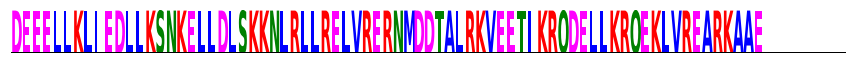

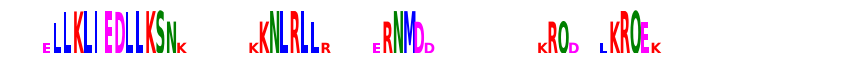

Test sequence 1:


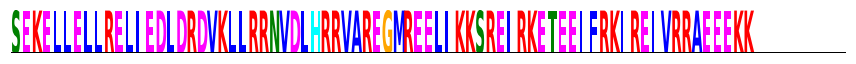

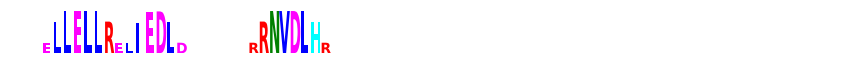

Test sequence 2:


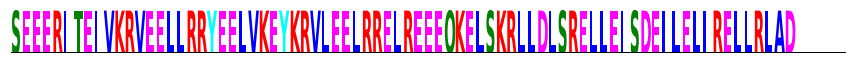

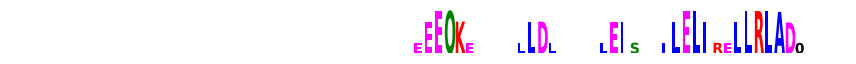

Test sequence 3:


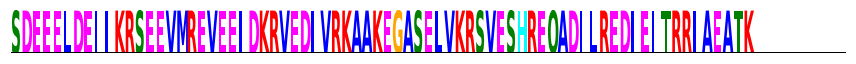

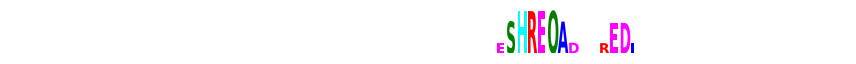

Test sequence 4:


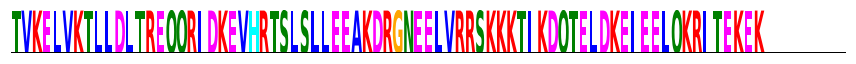

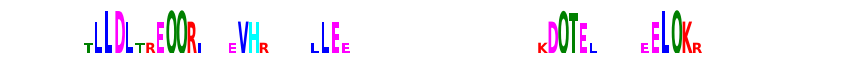

Binder 2:
Test sequence 0:


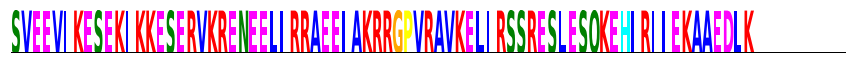

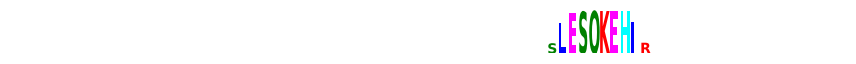

Test sequence 1:


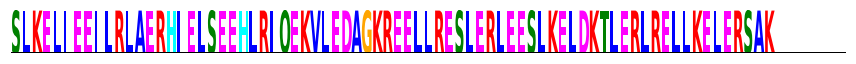

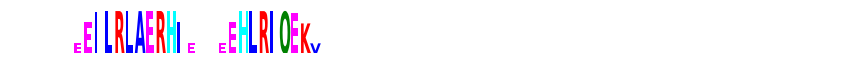

Test sequence 2:


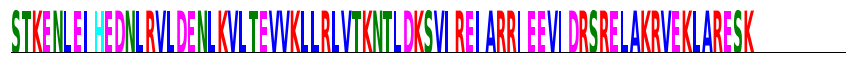

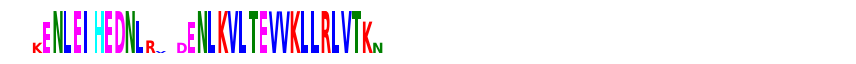

Test sequence 3:


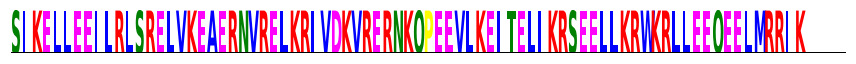

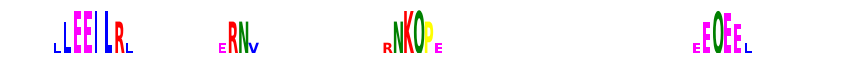

Test sequence 4:


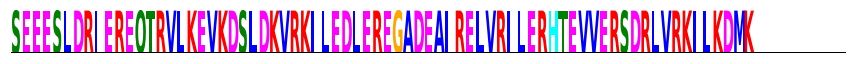

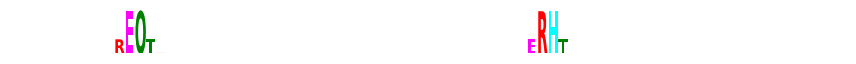

In [9]:
#Visualize importance for binder 1

print("Binder 1:")

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = "$" * 81

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)

#Visualize importance for binder 2

print("Binder 2:")

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = "$" * 81

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)


In [10]:
#Save predicted importance scores

model_name = "pytorch_saliency_" + dataset_name + "_smaller_blur"

np.save(model_name + "_importance_scores_1_test", importance_scores_1_test)


In [11]:
#Save predicted importance scores

model_name = "pytorch_saliency_" + dataset_name + "_smaller_blur"

np.save(model_name + "_importance_scores_2_test", importance_scores_2_test)
